# Matrix Factorisation - Linear & Non-Negative

In [8]:
import sys
sys.path.append("../")

In [9]:
import numpy as np
import pandas as pd
from IPython.display import SVG
import matplotlib.pyplot as plt
import seaborn as sns
from reco.preprocess import encode_user_item, random_split, user_split

In [10]:
%matplotlib inline

## Prepare the data

In [11]:
df_ratings = pd.read_csv("data/ratings.csv")

In [12]:
# Data Encoding
DATA = encode_user_item(df_ratings, "user_id", "movie_id", "rating", "unix_timestamp")

Number of users:  943
Number of items:  1682


In [13]:
DATA.head()

,user_id,movie_id,RATING,TIMESTAMP,USER,ITEM
0,196,242,3,881250949,195,241
1,186,302,3,891717742,185,301
2,22,377,1,878887116,21,376
3,244,51,2,880606923,243,50
4,166,346,1,886397596,165,345


In [25]:
n_users = DATA.USER.nunique()
n_items = DATA.ITEM.nunique()
n_users, n_items

(943, 1682)

In [26]:
max_rating = DATA.RATING.max()
min_rating = DATA.RATING.min()
min_rating, max_rating

(1, 5)

In [52]:
# Data Splitting
train, val, test = user_split(DATA, "TIMESTAMP", "USER", [0.6, 0.2, 0.2])

In [53]:
train.shape, val.shape, test.shape

((60014, 7), (19986, 7), (20000, 7))

## Explicit Matrix Factorisation 

This is a model with User and Item Embedding Dot Product

In [54]:
from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape
from keras.regularizers import l2
from keras.constraints import non_neg
from keras.utils.vis_utils import model_to_dot
from reco import vis

In [55]:
def ExplicitMF (n_users, n_items, n_factors):
    
    # Item Layer
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemsE')(item_embedding)

    # User Layer
    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, 
                               embeddings_regularizer=l2(1e-6), 
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUsersE')(user_embedding)

    # Dot Product of Item and User
    rating = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    
    # Model Creation
    model = Model([user_input, item_input], rating)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [56]:
n_factors = 40
model_explicit_mf = ExplicitMF(n_users, n_items, n_factors)

In [57]:
model_explicit_mf.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
____________________________________________________________________________________________

In [58]:
%%time
output_mf = model_explicit_mf.fit([train.USER, train.ITEM], train.RATING, 
                                  batch_size=128, epochs=5, verbose=1,
                                  validation_data=([val.USER, val.ITEM], val.RATING))



Train on 60014 samples, validate on 19986 samples
Epoch 1/5
60014/60014 [==============================] - 2s 32us/step - loss: 13.1868 - val_loss: 10.4685
Epoch 2/5
60014/60014 [==============================] - 1s 24us/step - loss: 4.6875 - val_loss: 1.8912
Epoch 3/5
60014/60014 [==============================] - 2s 29us/step - loss: 1.4287 - val_loss: 1.1837
Epoch 4/5
60014/60014 [==============================] - 1s 24us/step - loss: 1.0549 - val_loss: 1.0215
Epoch 5/5
60014/60014 [==============================] - 1s 24us/step - loss: 0.9430 - val_loss: 0.9603
CPU times: user 13.5 s, sys: 1.23 s, total: 14.7 s
Wall time: 8.62 s


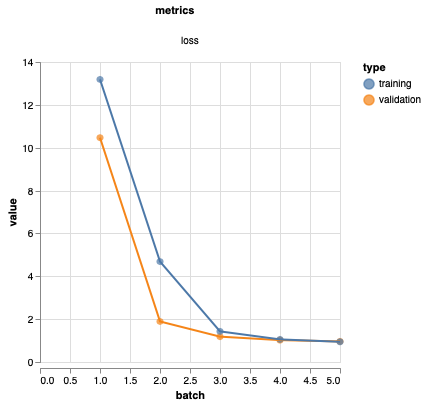

In [59]:
vis.metrics(output_mf.history)

In [61]:
score = model_explicit_mf.evaluate([test.USER, test.ITEM], test.RATING, verbose=1)
score

20000/20000 [==============================] - 1s 25us/step


0.9778011192321777

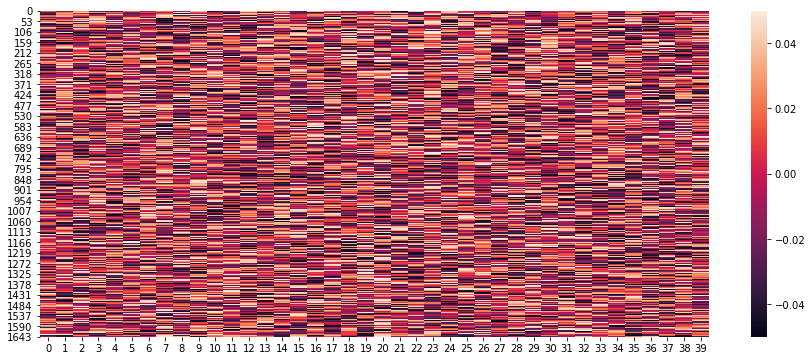

In [331]:
plot_item_embedding(model_mf)

## Model #2: Explicit Matrix Factorisation with Bias => Embedding Dot Product with Bias

In [344]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5), name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-5), name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [345]:
n_factors = 40
model_mf_bias = Explicit_MF_Bias(n_users, n_items, n_factors)

In [346]:
model_mf_bias.summary()

Model: "model_40"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
ItemEmbedding (Embedding)       (None, 1, 40)        67280       Item[0][0]                       
__________________________________________________________________________________________________
UserEmbedding (Embedding)       (None, 1, 40)        37720       User[0][0]                       
___________________________________________________________________________________________

In [347]:
%%time
output_mf_bias = model_mf_bias.fit([train.user_index, train.item_index], train.rating, batch_size=64, epochs=5, verbose=1,
                        validation_data=([val.user_index, val.item_index], val.rating))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 141us/step - loss: 1.3431 - val_loss: 1.0957
Epoch 2/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.9508 - val_loss: 0.9234
Epoch 3/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.8100 - val_loss: 0.8837
Epoch 4/5
60000/60000 [==============================] - 4s 66us/step - loss: 0.7189 - val_loss: 0.8741
Epoch 5/5
60000/60000 [==============================] - 4s 64us/step - loss: 0.6426 - val_loss: 0.8773
CPU times: user 34.6 s, sys: 2.9 s, total: 37.5 s
Wall time: 25.9 s


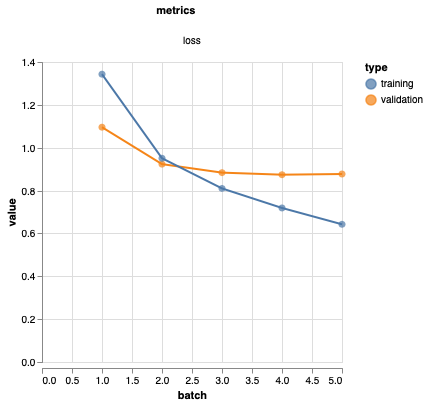

In [348]:
vis.metrics(output_mf_bias.history)

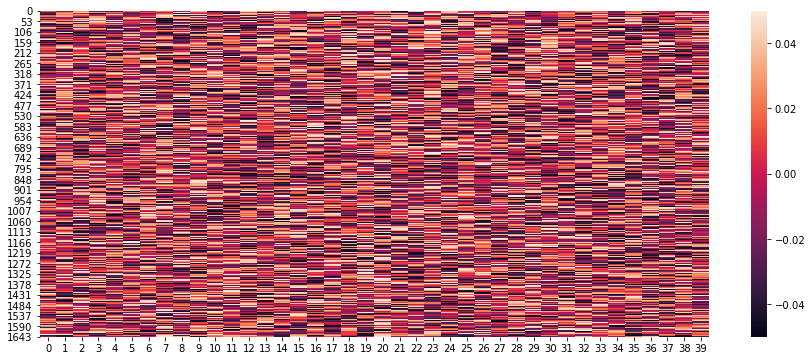

In [349]:
plot_item_embedding(model_mf_bias)

## Non-Negative Matrix Factorisation

In [353]:
def Explicit_MF_Bias(n_users, n_items, n_factors):
    
    # Item Layer
    item = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-5),
                               embeddings_constraint= non_neg(),
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    # Item Bias
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    # User Layer
    user = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-5), 
                               embeddings_constraint= non_neg(),
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    # User Bias
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    # Dot Product of Item and User & then Add Bias
    DotProduct = Dot(axes=1, name='DotProduct')([item_vec, user_vec])
    AddBias = Add(name="AddBias")([DotProduct, item_bias_vec, user_bias_vec])
    
    # Scaling for each user
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    # Model Creation
    model = Model([user_input, item_input], rating_output)
    
    # Compile Model
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [354]:
n_factors = 40
model_nnmf_bias = Explicit_MF_Bias(n_users, n_items, n_factors)

In [355]:
%%time
output_nnmf_bias = model_nnmf_bias.fit([train.user_index, train.item_index], train.rating, batch_size=64, epochs=5, verbose=1,
                        validation_data=([val.user_index, val.item_index], val.rating))

Train on 60000 samples, validate on 20000 samples
Epoch 1/5
60000/60000 [==============================] - 7s 109us/step - loss: 1.1830 - val_loss: 0.9838
Epoch 2/5
60000/60000 [==============================] - 4s 71us/step - loss: 0.9398 - val_loss: 0.9422
Epoch 3/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.9018 - val_loss: 0.9267
Epoch 4/5
60000/60000 [==============================] - 5s 75us/step - loss: 0.8805 - val_loss: 0.9171
Epoch 5/5
60000/60000 [==============================] - 4s 69us/step - loss: 0.8632 - val_loss: 0.9090
CPU times: user 37.2 s, sys: 4.56 s, total: 41.8 s
Wall time: 29 s


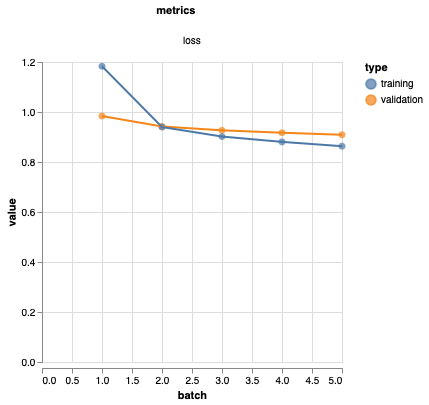

In [356]:
vis.metrics(output_nnmf_bias.history)

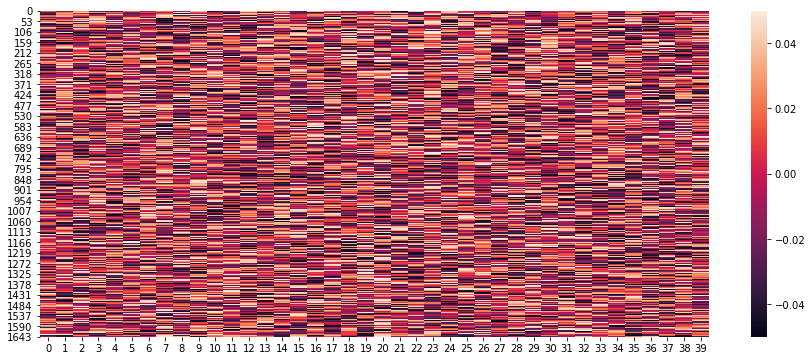

In [357]:
plot_item_embedding(model_nnmf_bias)